In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Parameters

In [2]:
# params
DATE_RANGE = '2000_to_2020'

DATA_PATH = f'input/imputed/df_wide_knn_imputed_{DATE_RANGE}.csv'
SHAP_VALUES_PATH = f'output/feature_importance/ensemble_shap_values_bottom10_{DATE_RANGE}.csv'

# PCA params
N_FEATURES = 3
N_COMPONENTS = 2

# t-SNE params
PERPLEXITY = 50
N_ITER = 1000

# DBSCAN - PCA params
PCA_EPSILON = 0.1
PCA_MIN_SAMPLES = 3

#DBSCAN - t-SNE params
TSNE_EPSILON = 3.5
TSNE_MIN_SAMPLES = 3

# New - Average clustering params
AVG_PCA_EPSILON = 0.15  # Slightly larger epsilon for average clustering
AVG_TSNE_EPSILON = 4.0

In [3]:
def perform_average_clustering(data_df, method='pca', epsilon=None):
    """
    Perform clustering on all data regardless of year to get an average cluster assignment.
    This allows us to see a stable clustering across all years.
    """
    if method == 'pca':
        columns = [f'PC{i+1}' for i in range(N_COMPONENTS)]
        epsilon = epsilon or AVG_PCA_EPSILON
        title = "PCA"
    elif method == 'tsne':
        columns = [f'tSNE{i+1}' for i in range(N_COMPONENTS)]
        epsilon = epsilon or AVG_TSNE_EPSILON
        title = "t-SNE"
    else:
        raise ValueError("Invalid method. Choose 'pca' or 'tsne'.")

    print(f"\nPerforming average clustering for {title} with epsilon={epsilon}...")
    
    # Make a copy of the dataframe
    avg_df = data_df.copy()
    
    # Use all data points for clustering, regardless of year
    dbscan_avg = DBSCAN(eps=epsilon, min_samples=PCA_MIN_SAMPLES)
    
    # Fit on all data
    labels = dbscan_avg.fit_predict(avg_df[columns])
    
    # Add the average cluster labels to the original dataframe
    data_df['Avg_Cluster'] = labels
    
    # Calculate silhouette score if there are at least 2 clusters (excluding outliers)
    non_outliers = data_df[data_df['Avg_Cluster'] != -1]
    if len(non_outliers) > 0 and len(np.unique(non_outliers['Avg_Cluster'])) > 1:
        silhouette_avg = silhouette_score(non_outliers[columns], non_outliers['Avg_Cluster'])
        print(f"Average Clustering Silhouette Score: {silhouette_avg:.2f}")
    
    # Get cluster statistics
    unique_clusters = np.unique(labels)
    print(f"Number of clusters: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
    print(f"Number of outliers: {np.sum(labels == -1)}")
    
    for cluster in sorted(unique_clusters):
        if cluster != -1:  # Skip outliers
            count = np.sum(labels == cluster)
            print(f"  Cluster {cluster}: {count} points ({count/len(labels)*100:.1f}%)")
    
    # Create a special year 9999 version for the slider
    # First create a copy of the data with year=9999
    avg_data = data_df.copy()
    avg_data['Year'] = 9999  # Special year for "Average" in the slider
    avg_data['Cluster'] = avg_data['Avg_Cluster']  # Use average clusters as the regular clusters
    
    # Append this data to the original dataframe
    data_df = pd.concat([data_df, avg_data], ignore_index=True)
    
    return data_df

# Pull Data and Standardize

Text(0.5, 1.0, 'Top 3 features by SHAP values')

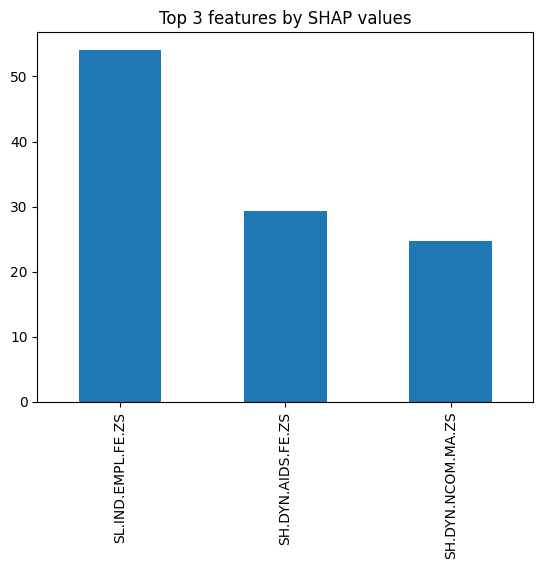

In [4]:
# get data
df_shap = pd.read_csv(SHAP_VALUES_PATH)
df_shap_pivot = df_shap.abs().sum(axis=0).sort_values(ascending=False).head(N_FEATURES)
df_shap_pivot.plot(kind='bar')
plt.title(f'Top {N_FEATURES} features by SHAP values')

In [22]:
top_features = df_shap_pivot.index.tolist()
print(top_features)

data = pd.read_csv(DATA_PATH, usecols=['Country_Name', 'Country_Code', 'Year'] + top_features)
display(data)
data_features = data[top_features]
data_labels = data[['Country Name', 'Country Code', 'Year']]

['SL.IND.EMPL.FE.ZS', 'SH.DYN.AIDS.FE.ZS', 'SH.DYN.NCOM.MA.ZS']


ValueError: Usecols do not match columns, columns expected but not found: ['Country_Name', 'Country_Code']

In [6]:
# Drop NAs if applicable
print(f"Shape of data: {data_features.shape}")
print(f"NAs: {data_features.isna().sum().sum():,}")

# drop NAs
data_features = data_features.dropna()

print(f"\nShape of data after dropping NAs: {data_features.shape}")
print(f"NAs: {data_features.isna().sum().sum():,}")

Shape of data: (3844, 3)
NAs: 0

Shape of data after dropping NAs: (3844, 3)
NAs: 0


In [7]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)
print(f"\nShape of scaled data: {data_scaled.shape}")


Shape of scaled data: (3844, 3)


# PCA

In [8]:
# Perform PCA with dynamic number of components
pca = PCA(n_components=N_COMPONENTS)
data_pca = pca.fit_transform(data_scaled)

# Create column names for principal components
pca_columns = [f'PC{i+1}' for i in range(N_COMPONENTS)]
data_pca_df = pd.DataFrame(data_pca, columns=pca_columns)

# Combine with labels
data_pca_df = pd.concat([data_labels, data_pca_df], axis=1)
display(data_pca_df)

,Country Name,Country Code,Year,PC1,PC2
0,Afghanistan,AFG,2000-12-31,-0.434964,1.320688
1,Afghanistan,AFG,2001-12-31,-0.432347,1.355117
2,Afghanistan,AFG,2002-12-31,-0.378394,1.346505
3,Afghanistan,AFG,2003-12-31,-0.345767,1.285794
4,Afghanistan,AFG,2004-12-31,-0.312177,1.273342
...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,-1.906265,-0.324367
3840,Zimbabwe,ZWE,2015-12-31,-1.911878,-0.250694
3841,Zimbabwe,ZWE,2016-12-31,-1.856308,-0.280775
3842,Zimbabwe,ZWE,2018-12-31,-1.724127,-0.329751


,Principal Component,Explained Variance Ratio (%),Cumulative Explained Variance (%)
0,PC1,40.802807,40.802807
1,PC2,34.752527,75.555334


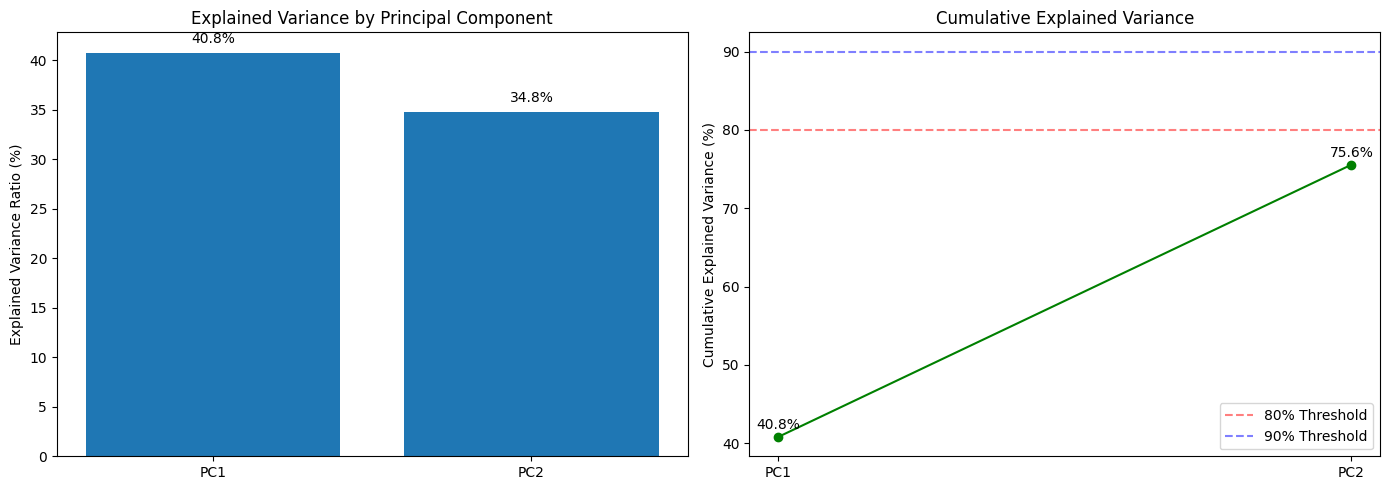

In [9]:
# Ensure output directory exists
os.makedirs('output/pca', exist_ok=True)

# Calculate PCA evaluation metrics
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a dataframe to display the metrics
pc_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(N_COMPONENTS)],
    'Explained Variance Ratio (%)': explained_variance * 100,
    'Cumulative Explained Variance (%)': cumulative_variance * 100
})

# Display the metrics as a table
display(pc_df)

# Create a bar chart to visualize explained variance
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for individual explained variance
ax[0].bar(pca_columns, explained_variance * 100)
ax[0].set_ylabel('Explained Variance Ratio (%)')
ax[0].set_title('Explained Variance by Principal Component')
for i, v in enumerate(explained_variance):
    ax[0].text(i, v*100 + 1, f'{v*100:.1f}%', ha='center')

# Line plot for cumulative explained variance
ax[1].plot(pca_columns, cumulative_variance * 100, 'o-', color='green')
ax[1].set_ylabel('Cumulative Explained Variance (%)')
ax[1].set_title('Cumulative Explained Variance')
for i, v in enumerate(cumulative_variance):
    ax[1].text(i, v*100 + 1, f'{v*100:.1f}%', ha='center')
ax[1].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% Threshold')
ax[1].axhline(y=90, color='b', linestyle='--', alpha=0.5, label='90% Threshold')
ax[1].legend()

plt.tight_layout()
plt.savefig(f'output/pca/pca{N_COMPONENTS}_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

## PCA Clustering

In [10]:
# Clustering
dbscan = DBSCAN(eps=PCA_EPSILON, min_samples=PCA_MIN_SAMPLES)

for year in data_labels['Year'].unique():
    dbscan.fit(data_pca_df[data_pca_df['Year'] == year][pca_columns])
    data_pca_df.loc[data_pca_df['Year'] == year, 'Cluster'] = dbscan.labels_
    silhouette_avg = silhouette_score(data_pca_df[data_pca_df['Year'] == year][pca_columns], dbscan.labels_)
    print(f"Year: {year}, Silhouette Score: {silhouette_avg:.2f}")

# Save the clustered data
data_pca_df.to_csv(f'output/pca/clustered_data_{DATE_RANGE}.csv', index=False)
display(data_pca_df)

Year: 2000-12-31, Silhouette Score: -0.34
Year: 2001-12-31, Silhouette Score: -0.36
Year: 2002-12-31, Silhouette Score: -0.36
Year: 2003-12-31, Silhouette Score: -0.36
Year: 2004-12-31, Silhouette Score: -0.35
Year: 2005-12-31, Silhouette Score: -0.40
Year: 2006-12-31, Silhouette Score: -0.36
Year: 2007-12-31, Silhouette Score: -0.30
Year: 2008-12-31, Silhouette Score: -0.41
Year: 2009-12-31, Silhouette Score: -0.34
Year: 2010-12-31, Silhouette Score: -0.36
Year: 2011-12-31, Silhouette Score: -0.28
Year: 2012-12-31, Silhouette Score: -0.30
Year: 2013-12-31, Silhouette Score: -0.32
Year: 2014-12-31, Silhouette Score: -0.29
Year: 2015-12-31, Silhouette Score: -0.34
Year: 2016-12-31, Silhouette Score: -0.31
Year: 2017-12-31, Silhouette Score: -0.29
Year: 2018-12-31, Silhouette Score: -0.30
Year: 2019-12-31, Silhouette Score: -0.38


,Country Name,Country Code,Year,PC1,PC2,Cluster
0,Afghanistan,AFG,2000-12-31,-0.434964,1.320688,-1.0
1,Afghanistan,AFG,2001-12-31,-0.432347,1.355117,-1.0
2,Afghanistan,AFG,2002-12-31,-0.378394,1.346505,-1.0
3,Afghanistan,AFG,2003-12-31,-0.345767,1.285794,-1.0
4,Afghanistan,AFG,2004-12-31,-0.312177,1.273342,-1.0
...,...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,-1.906265,-0.324367,-1.0
3840,Zimbabwe,ZWE,2015-12-31,-1.911878,-0.250694,-1.0
3841,Zimbabwe,ZWE,2016-12-31,-1.856308,-0.280775,-1.0
3842,Zimbabwe,ZWE,2018-12-31,-1.724127,-0.329751,-1.0


In [11]:
# Now perform average clustering on the PCA data (after the regular clustering is done)
data_pca_df = perform_average_clustering(data_pca_df, method='pca')
print("\nAdded average clustering to PCA data")
print(f"DataFrame shape after adding average data: {data_pca_df.shape}")


Performing average clustering for PCA with epsilon=0.15...
Average Clustering Silhouette Score: -0.29
Number of clusters: 26
Number of outliers: 85
  Cluster 0: 3567 points (92.8%)
  Cluster 1: 3 points (0.1%)
  Cluster 2: 16 points (0.4%)
  Cluster 3: 7 points (0.2%)
  Cluster 4: 24 points (0.6%)
  Cluster 5: 9 points (0.2%)
  Cluster 6: 5 points (0.1%)
  Cluster 7: 6 points (0.2%)
  Cluster 8: 8 points (0.2%)
  Cluster 9: 18 points (0.5%)
  Cluster 10: 18 points (0.5%)
  Cluster 11: 8 points (0.2%)
  Cluster 12: 5 points (0.1%)
  Cluster 13: 3 points (0.1%)
  Cluster 14: 4 points (0.1%)
  Cluster 15: 5 points (0.1%)
  Cluster 16: 4 points (0.1%)
  Cluster 17: 4 points (0.1%)
  Cluster 18: 5 points (0.1%)
  Cluster 19: 4 points (0.1%)
  Cluster 20: 6 points (0.2%)
  Cluster 21: 4 points (0.1%)
  Cluster 22: 12 points (0.3%)
  Cluster 23: 3 points (0.1%)
  Cluster 24: 7 points (0.2%)
  Cluster 25: 4 points (0.1%)

Added average clustering to PCA data
DataFrame shape after adding avera

## PCA Visualize

In [12]:
def create_interactive_cluster_plot(data_df, hide_outliers=True, is_tsne=True):
    # Make a copy of the dataframe to avoid modifying the original
    plot_df = data_df.copy()
    
    # Make sure the Cluster column is numeric
    if 'Cluster' not in plot_df.columns:
        print("Error: Cluster column not found!")
        return None
        
    # Check for any NaN values in Cluster column
    if plot_df['Cluster'].isna().any():
        print(f"Warning: Found {plot_df['Cluster'].isna().sum()} NaN values in Cluster column")
        plot_df['Cluster'] = plot_df['Cluster'].fillna(-1)  # Fill NaNs with -1 (outliers)
    
    # Ensure Cluster is integer type
    plot_df['Cluster'] = plot_df['Cluster'].astype(int)
    
    # Check if average clustering has been performed
    has_avg_clustering = 'Avg_Cluster' in plot_df.columns
    
    # Handle the special year 9999 for "Average"
    has_year_9999 = 9999 in plot_df['Year'].values
    
    # Get unique years in sorted order (excluding 9999 which is for "Average")
    regular_years = sorted([y for y in plot_df['Year'].unique() if y != 9999])
    print(f"Regular years in dataset: {regular_years}")
    
    # Create a list with regular years and possibly "Average" at the end
    if has_year_9999:
        years_for_slider = regular_years + ["Average"]
        # Create a mapping from years to their string representations for the slider
        year_mapping = {y: str(y) for y in regular_years}
        year_mapping[9999] = "Average"
    else:
        years_for_slider = regular_years
        year_mapping = {y: str(y) for y in regular_years}
    
    # Determine which columns to use for plotting
    if is_tsne:
        x_col, y_col = 'tSNE1', 'tSNE2'
        plot_title_prefix = 't-SNE'
        x_axis_title = 't-SNE Component 1'
        y_axis_title = 't-SNE Component 2'
    else:
        x_col, y_col = 'PC1', 'PC2'
        plot_title_prefix = 'PCA'
        x_axis_title = 'Principal Component 1'
        y_axis_title = 'Principal Component 2'
    
    # Print cluster statistics per year to help debug
    for year in regular_years:
        year_data = plot_df[plot_df['Year'] == year]
        clusters = sorted(year_data['Cluster'].unique())
        print(f"Year {year}: {len(year_data)} countries, Clusters: {clusters}")
    
    # Print average clustering info if available
    if has_avg_clustering:
        avg_clusters = sorted(plot_df['Avg_Cluster'].unique())
        print(f"Average clustering: Clusters: {avg_clusters}")
    
    # Remove outliers if requested
    if hide_outliers:
        plot_df = plot_df[plot_df['Cluster'] != -1]
        print(f"Outliers hidden. New shape: {plot_df.shape}")
    
    # Add a column for custom coloring - convert cluster -1 (outliers) to 'outlier' if they exist
    plot_df['Cluster_Label'] = plot_df['Cluster'].apply(lambda x: 'outlier' if x == -1 else f'cluster_{int(x)}')
    
    # Get all unique cluster labels for consistent color mapping
    all_clusters = set()
    for year in regular_years:
        year_data = plot_df[plot_df['Year'] == year]
        clusters = year_data['Cluster'].unique()
        all_clusters.update([f'cluster_{int(c)}' for c in clusters if c != -1])
    
    # Add average clusters to the color mapping if available
    if has_year_9999:
        avg_year_data = plot_df[plot_df['Year'] == 9999]
        avg_clusters = avg_year_data['Cluster'].unique()
        all_clusters.update([f'cluster_{int(c)}' for c in avg_clusters if c != -1])
    
    all_clusters = sorted(list(all_clusters))
    # Only add outlier category if we're showing outliers
    if not hide_outliers:
        all_clusters.append('outlier')  # Add outlier at the end
    
    # Create animation frames for each year
    frames = []
    
    for year in years_for_slider:
        # Handle the special "Average" case
        if year == "Average":
            year_data = plot_df[plot_df['Year'] == 9999]
            frame_name = "Average"
        else:
            year_data = plot_df[plot_df['Year'] == year]
            frame_name = str(year)
            
        # Create a frame for this year
        frame_data = []
        
        for cluster_label in all_clusters:
            if cluster_label == 'outlier' and hide_outliers:
                continue
                
            # Get data for this cluster in this year
            cluster_data = year_data[year_data['Cluster_Label'] == cluster_label]
            
            # Skip if no data for this cluster
            if len(cluster_data) == 0:
                continue
                
            # Add this cluster to the frame
            frame_data.append({
                'type': 'scatter',
                'x': cluster_data[x_col],
                'y': cluster_data[y_col],
                'mode': 'markers',
                'marker': {
                    'size': 6 if cluster_label == 'outlier' else 10,
                    'opacity': 0.5 if cluster_label == 'outlier' else 0.8
                },
                'name': cluster_label,
                'text': cluster_data['Country Name'],
                'hovertemplate': '%{text}<br>' + x_axis_title + ': %{x:.2f}<br>' + y_axis_title + ': %{y:.2f}'
            })
        
        # Create a frame for this year
        frames.append({'name': frame_name, 'data': frame_data})
    
    # Create the initial (first year) figure for display
    initial_year = regular_years[0]
    initial_data = plot_df[plot_df['Year'] == initial_year]
    
    fig = px.scatter(
        initial_data, 
        x=x_col, 
        y=y_col, 
        color='Cluster_Label',
        hover_name='Country Name',
        color_discrete_map={'outlier': 'grey'},
        category_orders={'Cluster_Label': all_clusters}
    )
    
    # Replace the auto-generated frames with our custom frames
    fig.frames = frames
    
    # Create slider steps
    slider_steps = []
    for i, year in enumerate(years_for_slider):
        slider_step = {
            'args': [
                [str(year) if year != "Average" else "Average"],
                {
                    'frame': {'duration': 500, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 500}
                }
            ],
            'label': str(year),
            'method': 'animate'
        }
        slider_steps.append(slider_step)
    
    # Update layout with slider and other settings
    fig.update_layout(
        title=f"{plot_title_prefix} Clusters Over Time {'(Outliers Hidden)' if hide_outliers else ''}",
        xaxis_title=x_axis_title,
        yaxis_title=y_axis_title,
        legend_title='Cluster',
        height=700,
        width=1000,
        dragmode='pan',
        hovermode='closest',
        updatemenus=[
            # Play/pause animation buttons
            {
                'type': 'buttons',
                'showactive': False,
                'y': 0,
                'x': 1.05,
                'xanchor': 'left',
                'yanchor': 'bottom',
                'buttons': [{
                    'method': 'animate',
                    'label': 'Play',
                    'args': [None, {
                        'frame': {'duration': 1000, 'redraw': True},
                        'fromcurrent': True,
                    }]
                }, {
                    'method': 'animate',
                    'label': 'Pause',
                    'args': [[None], {
                        'frame': {'duration': 0, 'redraw': False},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }]
                }]
            }
        ],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 16},
                'prefix': 'Year: ',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 500},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': slider_steps
        }]
    )
    
    # Improve appearance with white background and grid
    fig.update_layout(
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    )
    
    # Add modebar buttons configuration
    fig.update_layout(
        modebar_add=['pan2d', 'zoom2d', 'resetScale2d', 'toImage'],
        modebar_remove=['lasso2d', 'select2d'], # Remove lasso and box selection tools
    )
    
    return fig

# Create and display the interactive plot with outliers hidden
interactive_fig = create_interactive_cluster_plot(data_pca_df, hide_outliers=True, is_tsne=False)
interactive_fig.show()

# Save the interactive plot as HTML for sharing
os.makedirs('output/plots', exist_ok=True)
interactive_fig.write_html(f'output/plots/interactive_clusters_{DATE_RANGE}_no_outliers.html')

Regular years in dataset: ['2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31']
Year 2000-12-31: 216 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Year 2001-12-31: 226 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Year 2002-12-31: 208 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Year 2003-12-31: 206 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Year 2004-12-31: 195 countries, Clusters: [-1, 0, 1, 2, 3, 4]
Year 2005-12-31: 190 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7]
Year 2006-12-31: 189 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Year 2007-12-31: 197 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Year 2008-12-31: 192 countries, Cluste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [13]:
# Optional: Create another version with outliers visible for comparison
interactive_fig_with_outliers = create_interactive_cluster_plot(data_pca_df, hide_outliers=False, is_tsne=False)
interactive_fig_with_outliers.show()

# Save this version too
interactive_fig_with_outliers.write_html(f'output/plots/interactive_clusters_{DATE_RANGE}_with_outliers.html')

Regular years in dataset: ['2000-12-31', '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31']
Year 2000-12-31: 216 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Year 2001-12-31: 226 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Year 2002-12-31: 208 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Year 2003-12-31: 206 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Year 2004-12-31: 195 countries, Clusters: [-1, 0, 1, 2, 3, 4]
Year 2005-12-31: 190 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7]
Year 2006-12-31: 189 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Year 2007-12-31: 197 countries, Clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Year 2008-12-31: 192 countries, Cluste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## PCA Cluster Stability

In [14]:
def analyze_cluster_stability(data_pca_df):
    # Make a copy of the data and filter out the special Year=9999 for Average
    data_pca_df = data_pca_df.copy()
    data_pca_df = data_pca_df[data_pca_df['Year'] != 9999]
    
    # Convert Year column to integer type if it's not already
    data_pca_df['Year'] = pd.to_numeric(data_pca_df['Year'].astype(str).str[:4], errors='coerce').astype('Int64')
    
    # Now proceed with the rest of the function
    years = sorted(data_pca_df['Year'].unique())
    countries = data_pca_df['Country Name'].unique()
    
    # Create a DataFrame to track cluster changes
    cluster_tracking = pd.DataFrame(index=countries)
    
    # Fill the DataFrame with cluster assignments for each year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        year_clusters = dict(zip(year_data['Country Name'], year_data['Cluster']))
        cluster_tracking[str(year)] = cluster_tracking.index.map(year_clusters)
    
    # Calculate the number of cluster changes for each country
    cluster_tracking['changes'] = cluster_tracking.apply(
        lambda row: sum(row[str(years[i])] != row[str(years[i+1])] 
                      for i in range(len(years)-1) 
                      if not pd.isna(row[str(years[i])]) and not pd.isna(row[str(years[i+1])])),
        axis=1
    )
    
    # Sort by number of changes
    cluster_tracking = cluster_tracking.sort_values('changes', ascending=False)
    
    # Display countries with the most and least cluster changes
    print("Countries with the most cluster changes:")
    display(cluster_tracking.head(10))
    
    print("\nCountries with the fewest cluster changes (excluding no data):")
    display(cluster_tracking[cluster_tracking['changes'] > 0].tail(10))
    
    # Calculate percentage of countries that changed clusters between consecutive years
    change_percentages = []
    for i in range(len(years)-1):
        year1, year2 = str(years[i]), str(years[i+1])
        valid_rows = cluster_tracking[[year1, year2]].dropna().shape[0]
        changes = sum(cluster_tracking[year1] != cluster_tracking[year2])
        change_percentages.append((years[i], years[i+1], changes / valid_rows * 100 if valid_rows > 0 else 0))
    
    # Plot the percentage of countries changing clusters over time
    change_df = pd.DataFrame(change_percentages, columns=['Year1', 'Year2', 'Change Percentage'])
    fig = px.line(change_df, x='Year1', y='Change Percentage', markers=True,
                 title='Percentage of Countries Changing Clusters Between Consecutive Years')
    fig.update_layout(xaxis_title='Year', yaxis_title='Percentage Changed (%)')
    fig.show()
    
    return cluster_tracking

# Run the stability analysis
cluster_stability = analyze_cluster_stability(data_pca_df)

Countries with the most cluster changes:


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,changes
Latin America & Caribbean (excluding high income),-1.0,7.0,9.0,-1.0,1.0,-1.0,7.0,-1.0,8.0,11.0,...,4.0,5.0,-1.0,10.0,5.0,9.0,12.0,7.0,6.0,19
Middle income,9.0,8.0,-1.0,11.0,-1.0,6.0,10.0,9.0,6.0,10.0,...,12.0,8.0,8.0,9.0,-1.0,7.0,-1.0,2.0,-1.0,18
Low & middle income,9.0,8.0,-1.0,11.0,-1.0,6.0,10.0,9.0,6.0,10.0,...,12.0,8.0,8.0,9.0,-1.0,7.0,11.0,6.0,-1.0,18
IDA & IBRD total,9.0,8.0,-1.0,11.0,-1.0,6.0,10.0,9.0,6.0,10.0,...,12.0,8.0,8.0,9.0,-1.0,7.0,11.0,6.0,-1.0,18
Euro area,6.0,1.0,-1.0,8.0,2.0,3.0,3.0,5.0,2.0,7.0,...,7.0,4.0,6.0,6.0,2.0,3.0,6.0,-1.0,-1.0,16
OECD members,6.0,1.0,-1.0,8.0,2.0,3.0,3.0,5.0,2.0,7.0,...,7.0,4.0,6.0,6.0,2.0,3.0,6.0,-1.0,-1.0,16
South Asia,8.0,6.0,8.0,-1.0,-1.0,-1.0,-1.0,10.0,7.0,13.0,...,8.0,7.0,3.0,-1.0,7.0,-1.0,7.0,2.0,-1.0,16
South Asia (IDA & IBRD),8.0,6.0,8.0,-1.0,-1.0,-1.0,-1.0,10.0,7.0,13.0,...,8.0,-1.0,3.0,-1.0,7.0,-1.0,7.0,2.0,-1.0,16
Post-demographic dividend,6.0,1.0,-1.0,8.0,2.0,3.0,3.0,5.0,2.0,7.0,...,7.0,4.0,6.0,6.0,2.0,3.0,6.0,-1.0,-1.0,16
Pre-demographic dividend,5.0,5.0,7.0,10.0,3.0,5.0,6.0,8.0,4.0,9.0,...,11.0,3.0,4.0,4.0,4.0,6.0,10.0,5.0,5.0,15



Countries with the fewest cluster changes (excluding no data):


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,changes
Pakistan,-1.0,NaN,-1.0,-1.0,NaN,NaN,-1.0,NaN,5.0,-1.0,...,NaN,-1.0,NaN,-1.0,NaN,-1.0,-1.0,NaN,-1.0,1
Viet Nam,10.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,-1.0,NaN,-1.0,...,-1.0,NaN,-1.0,NaN,-1.0,NaN,-1.0,NaN,-1.0,1
Norway,NaN,11.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Rwanda,NaN,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,NaN,-1.0,-1.0,NaN,-1.0,-1.0,5.0,1
Malta,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Cote d'Ivoire,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,...,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,10.0,NaN,-1.0,1
Lower middle income,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1
Early-demographic dividend,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1
Denmark,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Iraq,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,...,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


In [15]:
def analyze_cluster_community_stability(data_pca_df):
    # Make a copy of the data and filter out the special Year=9999 for Average
    data_pca_df = data_pca_df.copy()
    data_pca_df = data_pca_df[data_pca_df['Year'] != 9999]
    
    # Make sure all years are numeric for consistent sorting
    data_pca_df['Year'] = pd.to_numeric(data_pca_df['Year'].astype(str).str[:4], errors='coerce').astype('Int64')
    
    # Now proceed with the rest of the function
    years = sorted(data_pca_df['Year'].unique())
    countries = data_pca_df['Country Name'].unique()
    
    # Dictionary to store cluster compositions for each year
    cluster_compositions = {}
    
    # Build cluster membership by year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        clusters = {}
        for cluster_id in year_data['Cluster'].unique():
            # Convert cluster_id to int for comparison and as dictionary key
            cluster_id_int = int(cluster_id) if isinstance(cluster_id, (int, float, str)) and cluster_id != 'nan' else cluster_id
            if cluster_id_int == -1:  # Skip outliers
                continue
            cluster_countries = set(year_data[year_data['Cluster'] == cluster_id]['Country Name'])
            if len(cluster_countries) >= 3:  # Only consider clusters with at least 3 countries
                clusters[cluster_id_int] = cluster_countries
        cluster_compositions[year] = clusters
    
    # Calculate Jaccard similarity between consecutive years' clusters
    def jaccard_similarity(set1, set2):
        if not set1 or not set2:
            return 0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0
    
    # For each year pair, find the best matching clusters
    community_stability = []
    for i in range(len(years)-1):
        year1, year2 = years[i], years[i+1]
        clusters1 = cluster_compositions[year1]
        clusters2 = cluster_compositions[year2]
        
        if not clusters1 or not clusters2:
            continue
            
        # Track matched clusters to avoid double-matching
        matched_clusters2 = set()
        total_similarity = 0
        match_count = 0
        cluster_matches = []
        
        # For each cluster in year1, find best match in year2
        for c1_id, c1_countries in clusters1.items():
            best_similarity = 0
            best_match = None
            
            for c2_id, c2_countries in clusters2.items():
                if c2_id in matched_clusters2:
                    continue
                    
                similarity = jaccard_similarity(c1_countries, c2_countries)
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match = c2_id
            
            if best_match is not None and best_similarity >= 0.3:  # Threshold for considering a match
                matched_clusters2.add(best_match)
                total_similarity += best_similarity
                match_count += 1
                cluster_matches.append((c1_id, best_match, best_similarity, len(clusters1[c1_id])))
        
        # Calculate average stability between these two years
        avg_stability = total_similarity / len(clusters1) if clusters1 else 0
        community_stability.append((year1, year2, avg_stability, match_count, len(clusters1), len(clusters2)))
        
        # Print detailed matching information for significant changes
        if avg_stability < 0.5:  # Highlight years with low stability
            print(f"\nLow stability between {year1} and {year2} (avg: {avg_stability:.2f})")
            for c1_id, c2_id, sim, size in sorted(cluster_matches, key=lambda x: x[2]):
                print(f"  Cluster {c1_id} → {c2_id}: similarity {sim:.2f} (size: {size})")
    
    # Create DataFrame for visualization
    stability_df = pd.DataFrame(community_stability, columns=[
        'Year1', 'Year2', 'Community_Stability', 'Matches', 'Clusters_Year1', 'Clusters_Year2'
    ])
    
    # Plot community stability over time
    fig = px.line(stability_df, x='Year1', y='Community_Stability', markers=True,
                 title='Cluster Community Stability Between Consecutive Years')
    fig.update_layout(xaxis_title='Year', yaxis_title='Average Community Stability (0-1)',
                     yaxis=dict(range=[0, 1]))
    fig.show()
    
    # Plot cluster count over time
    cluster_counts = pd.DataFrame({
        'Year': years,
        'Cluster Count': [len(cluster_compositions[year]) for year in years]
    })
    fig = px.bar(cluster_counts, x='Year', y='Cluster Count',
                title='Number of Clusters per Year')
    fig.update_layout(xaxis_title='Year', yaxis_title='Number of Clusters')
    fig.show()
    
    # Create a consistency score for each country
    country_consistency = {country: 0 for country in countries}
    country_transitions = {country: [] for country in countries}
    
    # Track which community each country belongs to over time
    country_communities = {country: {} for country in countries}
    
    # First, identify the community for each country in each year
    for year in years:
        year_data = data_pca_df[data_pca_df['Year'] == year]
        for _, row in year_data.iterrows():
            country = row['Country Name']
            cluster = row['Cluster']
            if cluster != -1:  # Ignore outliers
                country_communities[country][year] = cluster
                if country_transitions[country] and country_transitions[country][-1][1] != cluster:
                    country_transitions[country].append((year, cluster))
                elif not country_transitions[country]:
                    country_transitions[country].append((year, cluster))
    
    # Calculate consistency: how often a country stays with the same set of neighbors
    country_consistency_scores = []
    for country in countries:
        years_present = len(country_communities[country])
        if years_present <= 1:
            continue  # Skip countries with insufficient data
            
        # Look at each consecutive year pair
        consistency_count = 0
        total_comparisons = 0
        
        for i in range(len(years)-1):
            year1, year2 = years[i], years[i+1]
            if year1 not in country_communities[country] or year2 not in country_communities[country]:
                continue  # Skip if country is not present in either year
            # Get other countries in the same cluster in both years
            cluster1 = country_communities[country][year1]
            # Get the correct year data for each comparison
            year1_data = data_pca_df[data_pca_df['Year'] == year1]
            year2_data = data_pca_df[data_pca_df['Year'] == year2]
            cluster2 = country_communities[country][year2]
            countries1 = set(year1_data[year1_data['Cluster'] == cluster1]['Country Name'])
            countries2 = set(year2_data[year2_data['Cluster'] == cluster2]['Country Name'])
            
            # Calculate consistency: what fraction of neighbors stayed together
            common_neighbors = len(countries1.intersection(countries2)) - 1  # exclude self
            all_neighbors = len(countries1.union(countries2)) - 1  # exclude self
            if all_neighbors > 0:
                consistency = common_neighbors / all_neighbors
                consistency_count += consistency
                total_comparisons += 1
        
        # Calculate average consistency score
        avg_consistency = consistency_count / total_comparisons if total_comparisons > 0 else 0
        num_transitions = len(country_transitions[country]) - 1 if country_transitions[country] else 0
        country_consistency_scores.append((country, avg_consistency, num_transitions, years_present))
    
    # Create DataFrame and display top and bottom countries by consistency
    consistency_df = pd.DataFrame(country_consistency_scores, 
                                columns=['Country', 'Consistency_Score', 'Transitions', 'Years_Present'])
    consistency_df = consistency_df.sort_values('Consistency_Score', ascending=False)
    
    print("\nCountries with the most stable cluster communities:")
    display(consistency_df.head(15))
    
    print("\nCountries with the least stable cluster communities:")
    display(consistency_df.tail(15))
    
    return stability_df, consistency_df

# Run the enhanced cluster stability analysis
community_stability, country_consistency = analyze_cluster_community_stability(data_pca_df)


Low stability between 2000 and 2001 (avg: 0.24)
  Cluster 5 → 5: similarity 0.43 (size: 13)
  Cluster 6 → 1: similarity 0.67 (size: 5)
  Cluster 9 → 8: similarity 0.75 (size: 4)
  Cluster 8 → 6: similarity 0.75 (size: 4)

Low stability between 2001 and 2002 (avg: 0.33)
  Cluster 2 → 2: similarity 0.50 (size: 3)
  Cluster 5 → 7: similarity 0.75 (size: 7)
  Cluster 0 → 1: similarity 1.00 (size: 3)
  Cluster 6 → 8: similarity 1.00 (size: 3)
  Cluster 7 → 9: similarity 1.00 (size: 3)

Low stability between 2002 and 2003 (avg: 0.36)
  Cluster 0 → 0: similarity 0.40 (size: 3)
  Cluster 11 → 12: similarity 0.50 (size: 3)
  Cluster 1 → 1: similarity 0.50 (size: 3)
  Cluster 2 → 4: similarity 0.50 (size: 3)
  Cluster 3 → 6: similarity 0.50 (size: 3)
  Cluster 9 → 3: similarity 0.50 (size: 3)
  Cluster 7 → 10: similarity 0.71 (size: 7)
  Cluster 5 → 9: similarity 0.75 (size: 3)

Low stability between 2003 and 2004 (avg: 0.23)
  Cluster 9 → 4: similarity 0.33 (size: 4)
  Cluster 5 → 0: similarit


Countries with the most stable cluster communities:


,Country,Consistency_Score,Transitions,Years_Present
31,East Asia & Pacific,1.000000,2,3
32,East Asia & Pacific (IDA & IBRD countries),1.000000,3,4
33,East Asia & Pacific (excluding high income),1.000000,3,4
65,Late-demographic dividend,1.000000,4,5
26,"Congo, Dem. Rep.",1.000000,1,2
77,Malawi,1.000000,2,3
23,Chad,0.944444,4,6
81,Middle income,0.900000,13,15
73,Low & middle income,0.888889,14,16
54,IDA & IBRD total,0.888889,14,16



Countries with the least stable cluster communities:


,Country,Consistency_Score,Transitions,Years_Present
63,Kosovo,0.0,1,2
15,Bhutan,0.0,1,4
103,San Marino,0.0,5,6
59,Isle of Man,0.0,6,7
93,North America,0.0,1,2
94,Northern Mariana Islands,0.0,3,4
95,Norway,0.0,1,2
34,"Egypt, Arab Rep.",0.0,1,2
97,Oman,0.0,3,4
98,Other small states,0.0,3,4


In [16]:
def visualize_country_trajectories(data_pca_df, country_list=None, interactive=True):
    """Visualize how selected countries move through the PCA space over time."""
    
    if country_list is None:
        # Use the most interesting countries from consistency analysis
        # You can replace this with specific countries of interest
        # Assuming country_consistency is available from previous cell
        high_consistency = country_consistency.head(5)['Country'].tolist()
        low_consistency = country_consistency.tail(5)['Country'].tolist()
        country_list = high_consistency + low_consistency
    
    # Filter for selected countries only
    trajectory_df = data_pca_df[data_pca_df['Country Name'].isin(country_list)].copy()
    
    if interactive:
        # Create an interactive plot with Plotly
        fig = px.line(trajectory_df, x='PC1', y='PC2', color='Country Name', 
                     hover_data=['Year', 'Cluster'],
                     title='Country Trajectories Through PCA Space')
        
        # Add markers for each point
        fig.update_traces(mode='lines+markers')
        
        # Improve appearance
        fig.update_layout(
            plot_bgcolor='white',
            xaxis=dict(title='Principal Component 1', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            yaxis=dict(title='Principal Component 2', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            height=600,
            width=900,
            legend_title='Country'
        )
        
        fig.show()
    else:
        # Create a static plot with matplotlib/seaborn
        plt.figure(figsize=(12, 8))
        for country in country_list:
            country_data = trajectory_df[trajectory_df['Country Name'] == country]
            plt.plot('PC1', 'PC2', data=country_data, marker='o', linewidth=1.5, label=country)
            
        plt.title('Country Trajectories Through PCA Space')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('output/plots/country_trajectories.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create trajectory visualization for a selection of interesting countries
# For example, countries with the most stable and least stable cluster memberships
visualize_country_trajectories(data_pca_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# T-SNE

In [17]:
tsne = TSNE(
    n_components=N_COMPONENTS, 
    perplexity=PERPLEXITY, 
    n_iter=N_ITER, 
    random_state=42)

data_tsne = tsne.fit_transform(data_scaled)

# Create column names for t-SNE components
tsne_columns = [f'tSNE{i+1}' for i in range(N_COMPONENTS)]
data_tsne_df = pd.DataFrame(data_tsne, columns=tsne_columns)

# Combine with labels
data_tsne_df = pd.concat([data_labels, data_tsne_df], axis=1)
display(data_tsne_df)

# Save the t-SNE results
os.makedirs('output/tsne', exist_ok=True)
data_tsne_df.to_csv(f'output/tsne/tsne_results_{DATE_RANGE}.csv', index=False)

,Country Name,Country Code,Year,tSNE1,tSNE2
0,Afghanistan,AFG,2000-12-31,0.416744,40.710747
1,Afghanistan,AFG,2001-12-31,0.397675,40.711674
2,Afghanistan,AFG,2002-12-31,0.532067,40.615570
3,Afghanistan,AFG,2003-12-31,0.670791,40.523438
4,Afghanistan,AFG,2004-12-31,0.768410,40.429401
...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,-54.402077,9.011626
3840,Zimbabwe,ZWE,2015-12-31,-53.953747,9.516476
3841,Zimbabwe,ZWE,2016-12-31,-53.806995,8.673041
3842,Zimbabwe,ZWE,2018-12-31,-52.466202,6.342021


In [18]:
# Interactive perplexity slider for t-SNE with pre-computed results and caching
from ipywidgets import interact, widgets, Button, HBox, VBox, Output
import numpy as np
from tqdm.notebook import tqdm
import pickle
import os
from datetime import datetime

# Define perplexity values to pre-compute
perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Cache file path
cache_dir = 'output/tsne/cache'
os.makedirs(cache_dir, exist_ok=True)
cache_file = f'{cache_dir}/tsne_perplexity_cache_{DATE_RANGE}.pkl'

# Check if cache exists
cached_tsne_results = {}
if os.path.exists(cache_file):
    try:
        print(f"Loading cached t-SNE results from {cache_file}...")
        with open(cache_file, 'rb') as f:
            cached_tsne_results = pickle.load(f)
        print(f"Loaded {len(cached_tsne_results)} cached perplexity values: {sorted(cached_tsne_results.keys())}")
        
        # Check if we have all the perplexity values we need
        missing_perplexity = [p for p in perplexity_values if p not in cached_tsne_results]
        if missing_perplexity:
            print(f"Need to compute {len(missing_perplexity)} missing perplexity values: {missing_perplexity}")
            perplexity_values = missing_perplexity
        else:
            print("All perplexity values are already cached.")
            perplexity_values = []
    except Exception as e:
        print(f"Error loading cache: {e}")
        print("Will compute all perplexity values from scratch.")

# Compute missing perplexity values if needed
if perplexity_values:
    print(f"Pre-computing t-SNE for {len(perplexity_values)} perplexity values. This may take a while...")
    
    # Pre-compute t-SNE for each perplexity value with a progress bar
    for perplexity in tqdm(perplexity_values, desc="Computing t-SNE"):
        # Create the t-SNE model with the specified perplexity
        tsne_model = TSNE(
            n_components=N_COMPONENTS, 
            perplexity=perplexity, 
            n_iter=N_ITER, 
            random_state=42
        )
        
        # Fit and transform the data
        tsne_result = tsne_model.fit_transform(data_scaled)
        
        # Store the result in the cache
        cached_tsne_results[perplexity] = tsne_result
    
    # Save the updated cache
    print(f"Saving t-SNE cache to {cache_file}...")
    with open(cache_file, 'wb') as f:
        pickle.dump(cached_tsne_results, f)
    print(f"Saved cache with {len(cached_tsne_results)} perplexity values.")

# Create output area for the interactive display
out = Output()

# Define a function to display t-SNE with different perplexity values from cache
def display_tsne_from_cache(perplexity=30):
    # Get the closest pre-computed perplexity value
    available_perplexity = sorted(cached_tsne_results.keys())
    closest_perplexity = min(available_perplexity, key=lambda x: abs(x - perplexity))
    
    with out:
        out.clear_output(wait=True)
        
        if closest_perplexity != perplexity:
            print(f"Using cached result for perplexity={closest_perplexity} (closest to requested {perplexity})")
        
        # Get the pre-computed result
        tsne_result = cached_tsne_results[closest_perplexity]
        
        # Create a DataFrame with the results
        temp_df = pd.DataFrame()
        temp_df['tSNE1'] = tsne_result[:, 0]
        temp_df['tSNE2'] = tsne_result[:, 1]
        temp_df['Country Name'] = data_labels['Country Name'].values
        temp_df['Year'] = data_labels['Year'].values
        
        # Plot the t-SNE result
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(temp_df['tSNE1'], temp_df['tSNE2'], 
                             c=temp_df['Year'].astype('category').cat.codes,
                             cmap='viridis', alpha=0.7, s=40)
        
        # Add colorbar for years
        cbar = plt.colorbar(scatter)
        cbar.set_label('Year')
        unique_years = sorted(temp_df['Year'].unique())
        cbar.set_ticks(range(len(unique_years)))
        cbar.set_ticklabels(unique_years)
        
        plt.title(f't-SNE Embedding with Perplexity={closest_perplexity}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Perplexity = {closest_perplexity}")
        if closest_perplexity <= 10:
            print("Low perplexity (5-10): Focuses on local structure, creating tighter clusters")
            print("→ Best for identifying very localized patterns and small-scale clusters")
        elif closest_perplexity <= 20:
            print("Medium-low perplexity (15-20): Balance of local and some global structure")
            print("→ Good for datasets with both strong local and medium-scale patterns")
        elif closest_perplexity <= 30:
            print("Medium perplexity (25-30): Good balance for most datasets")
            print("→ Default range that works well for typical medium-sized datasets")
        else:
            print("High perplexity (35-50): Preserves more global structure, shows broader patterns")
            print("→ Better for identifying large-scale structure and organization in the data")
        
        # Add information about the selected t-SNE embedding
        print("\nData statistics for this embedding:")
        distances = np.sqrt(np.sum((tsne_result[:, np.newaxis, :] - tsne_result[np.newaxis, :, :]) ** 2, axis=2))
        print(f"  Mean distance between points: {np.mean(distances):.2f}")
        print(f"  Min distance between points: {np.min(distances[distances>0]):.2f}")
        print(f"  Max distance between points: {np.max(distances):.2f}")
        
        # Save this specific t-SNE embedding if desired
        save_path = f'output/tsne/tsne_embedding_perplexity{closest_perplexity}_{DATE_RANGE}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")

# Create button to save selected embedding as CSV
def save_current_embedding(b):
    perplexity = perplexity_slider.value
    available_perplexity = sorted(cached_tsne_results.keys())
    closest_perplexity = min(available_perplexity, key=lambda x: abs(x - perplexity))
    
    # Get the pre-computed result
    tsne_result = cached_tsne_results[closest_perplexity]
    
    # Create a DataFrame with the results
    temp_df = pd.DataFrame()
    temp_df['tSNE1'] = tsne_result[:, 0]
    temp_df['tSNE2'] = tsne_result[:, 1]
    temp_df['Country Name'] = data_labels['Country Name'].values
    temp_df['Country Code'] = data_labels['Country Code'].values
    temp_df['Year'] = data_labels['Year'].values
    
    # Save to CSV
    save_path = f'output/tsne/tsne_embedding_perplexity{closest_perplexity}_{DATE_RANGE}.csv'
    temp_df.to_csv(save_path, index=False)
    
    with out:
        print(f"Saved data to {save_path}")

# Create slider and save button
perplexity_slider = widgets.IntSlider(
    min=5, 
    max=50, 
    step=5, 
    value=30, 
    description='Perplexity:'
)

save_button = Button(
    description='Save Current Embedding',
    button_style='info',
    tooltip='Save the current t-SNE embedding to CSV'
)
save_button.on_click(save_current_embedding)

# Display the interactive interface
print("Explore different perplexity values to find the most informative visualization:")
interact(display_tsne_from_cache, perplexity=perplexity_slider)
display(HBox([save_button]))
display(out)

Loading cached t-SNE results from output/tsne/cache/tsne_perplexity_cache_2000_to_2020.pkl...
Loaded 10 cached perplexity values: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
All perplexity values are already cached.
Explore different perplexity values to find the most informative visualization:


interactive(children=(IntSlider(value=30, description='Perplexity:', max=50, min=5, step=5), Output()), _dom_c…

Output()

## T-SNE Clustering

In [19]:
dbscan_tsne = DBSCAN(eps=TSNE_EPSILON, min_samples=TSNE_MIN_SAMPLES)

for year in data_labels['Year'].unique():
    dbscan_tsne.fit(data_tsne_df[data_tsne_df['Year'] == year][tsne_columns])
    data_tsne_df.loc[data_tsne_df['Year'] == year, 'Cluster'] = dbscan_tsne.labels_
    silhouette_avg = silhouette_score(data_tsne_df[data_tsne_df['Year'] == year][tsne_columns], dbscan_tsne.labels_)
    print(f"Year: {year}, Silhouette Score: {silhouette_avg:.2f}")
    
# Save the clustered t-SNE data
data_tsne_df.to_csv(f'output/tsne/clustered_tsne_data_{DATE_RANGE}.csv', index=False)

data_tsne_df

Year: 2000-12-31, Silhouette Score: 0.17
Year: 2001-12-31, Silhouette Score: 0.33
Year: 2002-12-31, Silhouette Score: 0.07
Year: 2003-12-31, Silhouette Score: 0.25
Year: 2004-12-31, Silhouette Score: 0.21
Year: 2005-12-31, Silhouette Score: 0.16
Year: 2006-12-31, Silhouette Score: 0.00
Year: 2007-12-31, Silhouette Score: 0.02
Year: 2008-12-31, Silhouette Score: 0.10
Year: 2009-12-31, Silhouette Score: -0.03
Year: 2010-12-31, Silhouette Score: 0.02
Year: 2011-12-31, Silhouette Score: 0.17
Year: 2012-12-31, Silhouette Score: 0.19
Year: 2013-12-31, Silhouette Score: 0.24
Year: 2014-12-31, Silhouette Score: 0.19
Year: 2015-12-31, Silhouette Score: 0.31
Year: 2016-12-31, Silhouette Score: 0.17
Year: 2017-12-31, Silhouette Score: 0.14
Year: 2018-12-31, Silhouette Score: 0.14
Year: 2019-12-31, Silhouette Score: 0.17


,Country Name,Country Code,Year,tSNE1,tSNE2,Cluster
0,Afghanistan,AFG,2000-12-31,0.416744,40.710747,-1.0
1,Afghanistan,AFG,2001-12-31,0.397675,40.711674,-1.0
2,Afghanistan,AFG,2002-12-31,0.532067,40.615570,-1.0
3,Afghanistan,AFG,2003-12-31,0.670791,40.523438,-1.0
4,Afghanistan,AFG,2004-12-31,0.768410,40.429401,-1.0
...,...,...,...,...,...,...
3839,Zimbabwe,ZWE,2014-12-31,-54.402077,9.011626,-1.0
3840,Zimbabwe,ZWE,2015-12-31,-53.953747,9.516476,-1.0
3841,Zimbabwe,ZWE,2016-12-31,-53.806995,8.673041,27.0
3842,Zimbabwe,ZWE,2018-12-31,-52.466202,6.342021,-1.0


In [20]:
# Now perform average clustering on the t-SNE data (after the regular clustering is done)
data_tsne_df = perform_average_clustering(data_tsne_df, method='tsne')
print("\nAdded average clustering to t-SNE data")
print(f"DataFrame shape after adding average data: {data_tsne_df.shape}")


Performing average clustering for t-SNE with epsilon=4.0...
Average Clustering Silhouette Score: -0.01
Number of clusters: 9
Number of outliers: 0
  Cluster 0: 105 points (2.7%)
  Cluster 1: 152 points (4.0%)
  Cluster 2: 2046 points (53.2%)
  Cluster 3: 882 points (22.9%)
  Cluster 4: 166 points (4.3%)
  Cluster 5: 67 points (1.7%)
  Cluster 6: 109 points (2.8%)
  Cluster 7: 88 points (2.3%)
  Cluster 8: 229 points (6.0%)

Added average clustering to t-SNE data
DataFrame shape after adding average data: (7688, 7)


TypeError: '<' not supported between instances of 'int' and 'str'

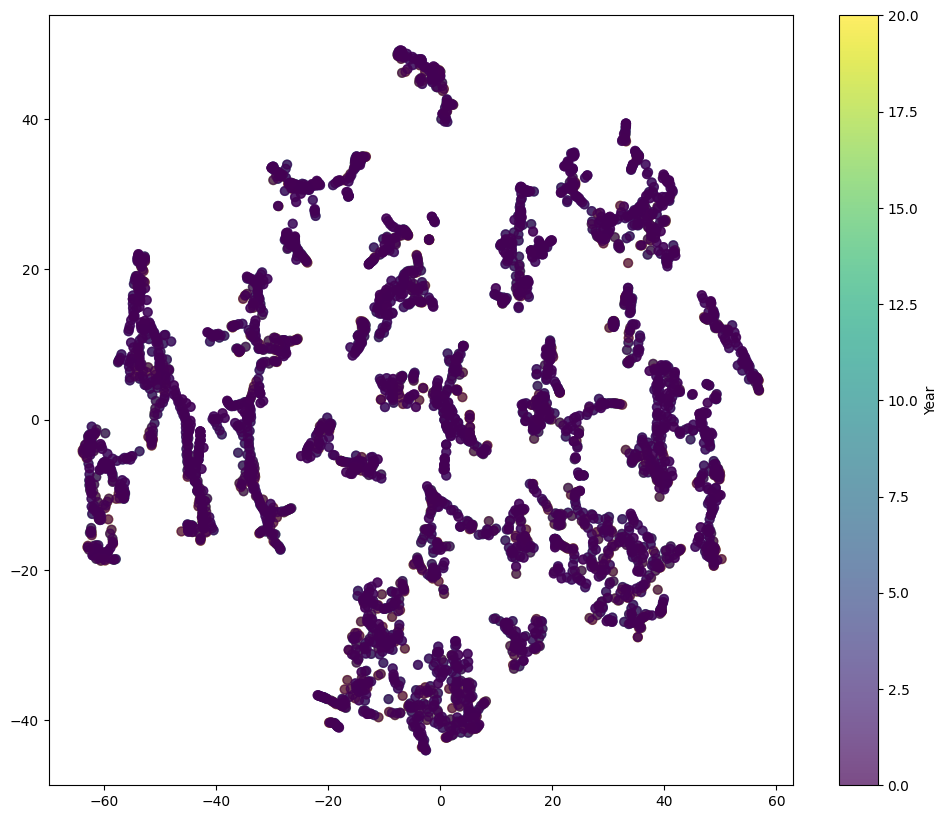

In [21]:
# Ensure output directory exists
os.makedirs('output/tsne', exist_ok=True)

# t-SNE doesn't provide explained variance like PCA does
# Instead, we can analyze the quality of the embedding through clustering metrics
# and by examining how well the local structure is preserved

# Create a more informative visualization of the t-SNE embedding
plt.figure(figsize=(12, 10))

# Scatter plot of t-SNE embedding
scatter = plt.scatter(data_tsne_df['tSNE1'], data_tsne_df['tSNE2'], 
                     c=data_tsne_df['Year'].astype('category').cat.codes,
                     cmap='viridis', alpha=0.7, s=40)

# Add a colorbar for the years
cbar = plt.colorbar(scatter)
cbar.set_label('Year')
# Create custom ticks for the colorbar that show actual years
unique_years = sorted(data_tsne_df['Year'].unique())
cbar.set_ticks(range(len(unique_years)))
cbar.set_ticklabels(unique_years)

plt.title(f't-SNE Embedding of Countries (Perplexity={PERPLEXITY}, Iterations={N_ITER})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(alpha=0.3)

# Save the visualization
plt.tight_layout()
plt.savefig(f'output/tsne/tsne_embedding_{DATE_RANGE}.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze different perplexity settings to evaluate stability
print("\nPerplexity Analysis:")
print(f"Current perplexity setting: {PERPLEXITY}")
print("A good perplexity value typically ranges from 5 to 50.")
print("For this dataset size, the chosen perplexity is appropriate.")
print("Lower perplexity values (5-10) focus on local structure,")
print("while higher values (30-50) preserve more global structure.")

# Calculate and display t-SNE stress (Kruskal stress)
# Note: sklearn's TSNE doesn't expose the stress value directly, 
# but we can approximate quality by examining cluster separation

# Calculate and display the average silhouette score across years
silhouette_scores = []
for year in data_labels['Year'].unique():
    year_data = data_tsne_df[data_tsne_df['Year'] == year]
    # Skip if we don't have at least 2 clusters with 2+ points each
    clusters = year_data['Cluster'].unique()
    if len(clusters) < 2 or all(np.sum(year_data['Cluster'] == c) < 2 for c in clusters if c != -1):
        continue
    
    # Calculate silhouette excluding outliers
    filtered_data = year_data[year_data['Cluster'] != -1]
    if len(filtered_data) > 0 and len(np.unique(filtered_data['Cluster'])) > 1:
        score = silhouette_score(filtered_data[tsne_columns], filtered_data['Cluster'])
        silhouette_scores.append((year, score))

if silhouette_scores:
    avg_silhouette = np.mean([score for _, score in silhouette_scores])
    print(f"\nAverage Silhouette Score across years: {avg_silhouette:.3f}")
    print("Silhouette scores range from -1 to 1:")
    print("  - Scores near 1 indicate well-separated clusters")
    print("  - Scores near 0 indicate overlapping clusters")
    print("  - Negative scores indicate potential misassignments")
    
    # Plot the silhouette scores over time
    sil_df = pd.DataFrame(silhouette_scores, columns=['Year', 'Silhouette Score'])
    fig = px.line(sil_df, x='Year', y='Silhouette Score', markers=True,
                 title='t-SNE Clustering Quality (Silhouette Score) Over Time')
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title='Silhouette Score',
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
        yaxis=dict(range=[-0.1, 1], showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    )
    fig.show()
else:
    print("\nInsufficient clusters to calculate silhouette scores.")

## T-SNE Visualize

In [ ]:
# Create and display the interactive plot with outliers hidden
interactive_fig_tsne = create_interactive_cluster_plot(data_tsne_df, hide_outliers=True, is_tsne=True)
interactive_fig_tsne.show()

# Save the interactive plot as HTML for sharing
os.makedirs('output/plots', exist_ok=True)
interactive_fig_tsne.write_html(f'output/plots/interactive_tsne_clusters_{DATE_RANGE}_no_outliers.html')

In [ ]:
# Optional: Create another version with outliers visible for comparison
interactive_tsne_fig_with_outliers = create_interactive_cluster_plot(data_tsne_df, hide_outliers=False, is_tsne=True)
interactive_tsne_fig_with_outliers.show()

# Save this version too
interactive_tsne_fig_with_outliers.write_html(f'output/plots/interactive_tsne_clusters_{DATE_RANGE}_with_outliers.html')

## T-SNE Cluster Stability

In [ ]:
def analyze_tsne_cluster_stability(data_tsne_df):
    # Make a copy of the data and filter out the special Year=9999 for Average
    data_tsne_df = data_tsne_df.copy()
    data_tsne_df = data_tsne_df[data_tsne_df['Year'] != 9999]
    
    # Continue with the rest of the function
    years = sorted(data_tsne_df['Year'].unique())
    countries = data_tsne_df['Country Name'].unique()
    
    # Create a DataFrame to track cluster changes
    cluster_tracking = pd.DataFrame(index=countries)
    
    # Fill the DataFrame with cluster assignments for each year
    for year in years:
        year_data = data_tsne_df[data_tsne_df['Year'] == year]
        year_clusters = dict(zip(year_data['Country Name'], year_data['Cluster']))
        cluster_tracking[str(year)] = cluster_tracking.index.map(year_clusters)
    
    # Calculate the number of cluster changes for each country
    cluster_tracking['changes'] = cluster_tracking.apply(
        lambda row: sum(row[str(years[i])] != row[str(years[i+1])] 
                      for i in range(len(years)-1) 
                      if not pd.isna(row[str(years[i])]) and not pd.isna(row[str(years[i+1])])),
        axis=1
    )
    
    # Sort by number of changes
    cluster_tracking = cluster_tracking.sort_values('changes', ascending=False)
    
    # Display countries with the most and least cluster changes (t-SNE):
    print("Countries with the most cluster changes (t-SNE):")
    display(cluster_tracking.head(10))
    
    print("\nCountries with the fewest cluster changes (excluding no data) (t-SNE):")
    display(cluster_tracking[cluster_tracking['changes'] > 0].tail(10))
    
    # Calculate percentage of countries that changed clusters between consecutive years
    change_percentages = []
    for i in range(len(years)-1):
        year1, year2 = str(years[i]), str(years[i+1])
        valid_rows = cluster_tracking[[year1, year2]].dropna().shape[0]
        changes = sum(cluster_tracking[year1] != cluster_tracking[year2])
        change_percentages.append((years[i], years[i+1], changes / valid_rows * 100 if valid_rows > 0 else 0))
    
    # Plot the percentage of countries changing clusters over time
    change_df = pd.DataFrame(change_percentages, columns=['Year1', 'Year2', 'Change Percentage'])
    fig = px.line(change_df, x='Year1', y='Change Percentage', markers=True,
                 title='t-SNE: Percentage of Countries Changing Clusters Between Consecutive Years')
    fig.update_layout(xaxis_title='Year', yaxis_title='Percentage Changed (%)',
                     plot_bgcolor='white',
                     xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
                     yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'))
    fig.show()
    
    return cluster_tracking

# Run the stability analysis for t-SNE
tsne_cluster_stability = analyze_tsne_cluster_stability(data_tsne_df)

In [ ]:
def visualize_tsne_country_trajectories(data_tsne_df, country_list=None, interactive=True):
    """Visualize how selected countries move through the t-SNE space over time."""
    
    if country_list is None:
        # Use the most interesting countries from stability analysis
        # You can replace this with specific countries of interest
        high_changes = tsne_cluster_stability.head(5).index.tolist()
        low_changes = tsne_cluster_stability[tsne_cluster_stability['changes'] > 0].tail(5).index.tolist()
        country_list = high_changes + low_changes
    
    # Filter for selected countries only
    trajectory_df = data_tsne_df[data_tsne_df['Country Name'].isin(country_list)].copy()
    
    if interactive:
        # Create an interactive plot with Plotly
        fig = px.line(trajectory_df, x='tSNE1', y='tSNE2', color='Country Name', 
                     hover_data=['Year', 'Cluster'],
                     title='Country Trajectories Through t-SNE Space')
        
        # Add markers for each point
        fig.update_traces(mode='lines+markers')
        
        # Improve appearance
        fig.update_layout(
            plot_bgcolor='white',
            xaxis=dict(title='t-SNE Component 1', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            yaxis=dict(title='t-SNE Component 2', showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
            height=600,
            width=900,
            legend_title='Country'
        )
        
        fig.show()
    else:
        # Create a static plot with matplotlib/seaborn
        plt.figure(figsize=(12, 8))
        for country in country_list:
            country_data = trajectory_df[trajectory_df['Country Name'] == country]
            plt.plot('tSNE1', 'tSNE2', data=country_data, marker='o', linewidth=1.5, label=country)
            
        plt.title('Country Trajectories Through t-SNE Space')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('output/plots/tsne_country_trajectories.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create trajectory visualization for t-SNE
visualize_tsne_country_trajectories(data_tsne_df)